In [193]:
__author__ = 'Jared Paul Guevara'

In [194]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# Fetching dataset from UCI's Machine Learning Repository
heart_failure_data = fetch_ucirepo(id=519)

# Separating features from target variable
X = heart_failure_data.data.features
y = heart_failure_data.data.targets

print('Size of dataset:', len(X))
assert(len(X) == len(y))
heart_failure_data['variables'][['name', 'description', 'units']]

Size of dataset: 299


,name,description,units
0,age,age of the patient,years
1,anaemia,decrease of red blood cells or hemoglobin,None
2,creatinine_phosphokinase,level of the CPK enzyme in the blood,mcg/L
3,diabetes,if the patient has diabetes,None
4,ejection_fraction,percentage of blood leaving the heart at each ...,%
5,high_blood_pressure,if the patient has hypertension,None
6,platelets,platelets in the blood,kiloplatelets/mL
7,serum_creatinine,level of serum creatinine in the blood,mg/dL
8,serum_sodium,level of serum sodium in the blood,mEq/L
9,sex,woman or man,None


In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

assert(len(X_train) > len(X_test))
assert(len(X_train) == round(299 - (299 * 0.33)))
assert(len(X_test) == round(299 * 0.33))
print('Size of training data:', len(X_train))
print('Size of test data:', len(X_test))

Size of training data: 200
Size of test data: 99


In [196]:
train = X.join(y)
train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [197]:
train_grouped = train.groupby('death_event').mean()
train_grouped

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
death_event,,,,,,,,,,,,
0,58.761906,0.408867,540.054187,0.418719,40.26601,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901
1,65.215281,0.479167,670.197917,0.416667,33.46875,0.406250,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417


In [198]:
import matplotlib.pyplot as plt
import seaborn as sns

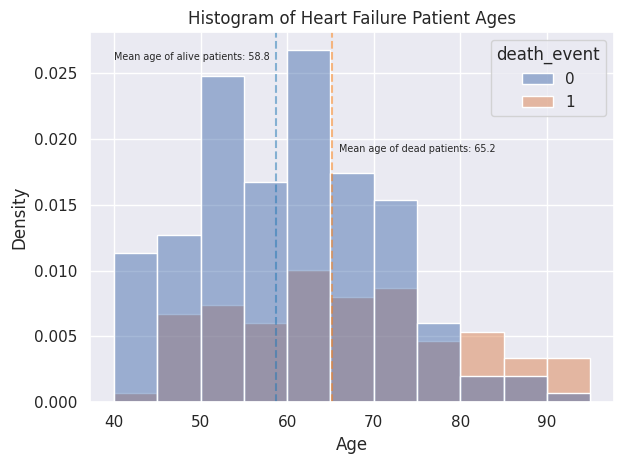

In [199]:
sns.histplot(train, x='age', 
             hue='death_event',
             stat='density',
             binwidth=5)
plt.axvline(train_grouped['age'][0],
            alpha=0.5, 
            c='tab:blue',
            ls='--')
plt.axvline(train_grouped['age'][1],
            alpha=0.5,
            c='tab:orange',
            ls='--'),
plt.annotate(f"Mean age of alive patients: {train_grouped['age'][0]:.1f}",
             xy=(train_grouped['age'][0], 0.025),
             xytext=(40, 0.026),
             size='xx-small')
plt.annotate(f"Mean age of dead patients: {train_grouped['age'][1]:.1f}",
             xy=(train_grouped['age'][1], 0.025),
             xytext=(66, 0.019),
             size='xx-small')
plt.title('Histogram of Heart Failure Patient Ages')
plt.xlabel('Age')
plt.tight_layout() 

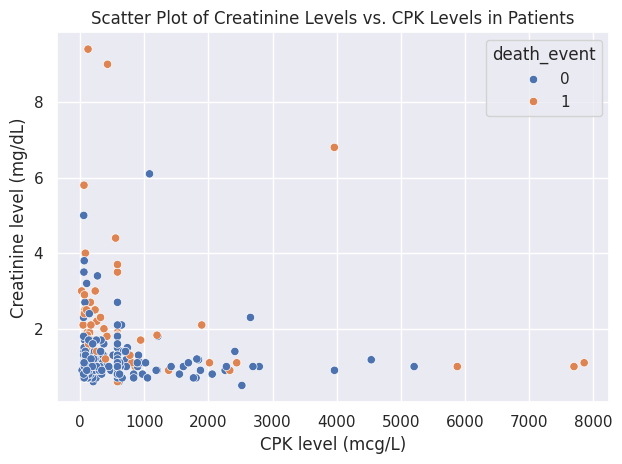

In [200]:
# Creatine <-CPK-> phosphocreatine -breakdown-> creatinine (waste product)
sns.scatterplot(train, x='creatinine_phosphokinase', y='serum_creatinine', hue='death_event')
plt.title('Scatter Plot of Creatinine Levels vs. CPK Levels in Patients')
plt.xlabel('CPK level (mcg/L)')
plt.ylabel('Creatinine level (mg/dL)')
plt.tight_layout()


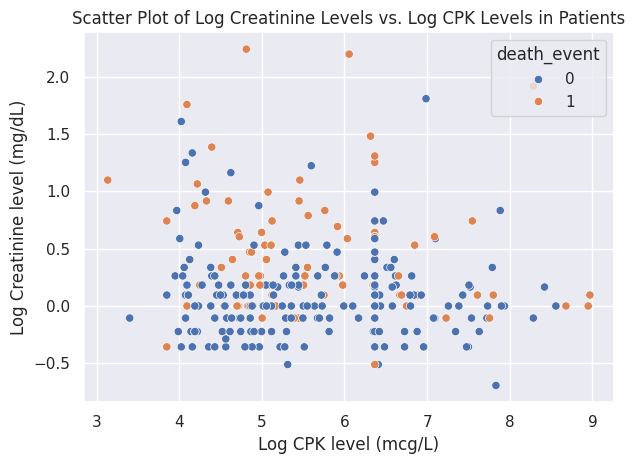

In [201]:
sns.scatterplot(train, x=np.log(train['creatinine_phosphokinase']), y=np.log(train['serum_creatinine']), hue='death_event')
plt.title('Scatter Plot of Log Creatinine Levels vs. Log CPK Levels in Patients')
plt.xlabel('Log CPK level (mcg/L)')
plt.ylabel('Log Creatinine level (mg/dL)')
plt.tight_layout()

61


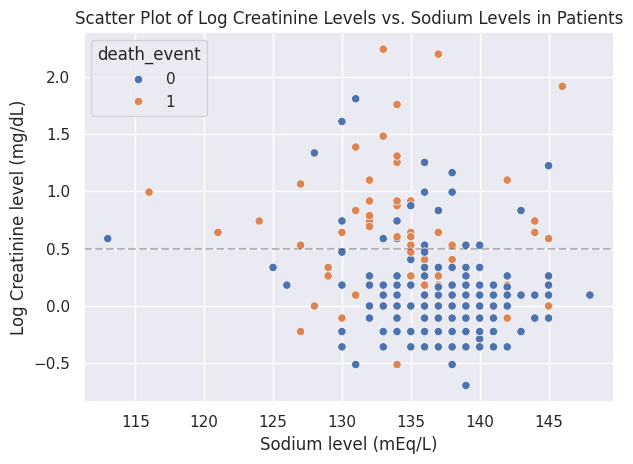

In [202]:
sns.scatterplot(train, x='serum_sodium', y=np.log(train['serum_creatinine']), hue='death_event')
plt.title('Scatter Plot of Log Creatinine Levels vs. Sodium Levels in Patients')
plt.axhline(0.5,
            alpha=0.25,
            c='black',
            ls='--')
plt.xlabel('Sodium level (mEq/L)')
plt.ylabel('Log Creatinine level (mg/dL)')
plt.tight_layout()
print(len(train[np.log(train['serum_creatinine']) > 0.5]))

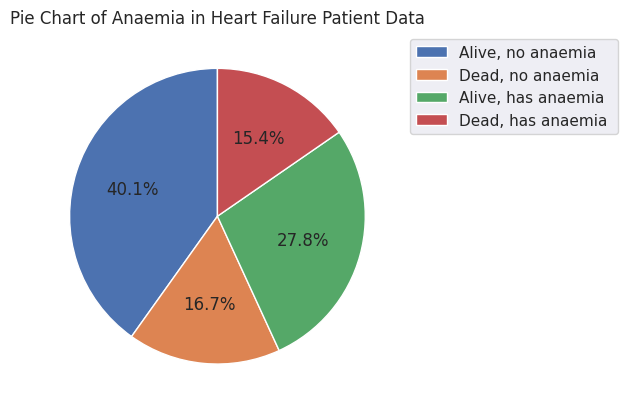

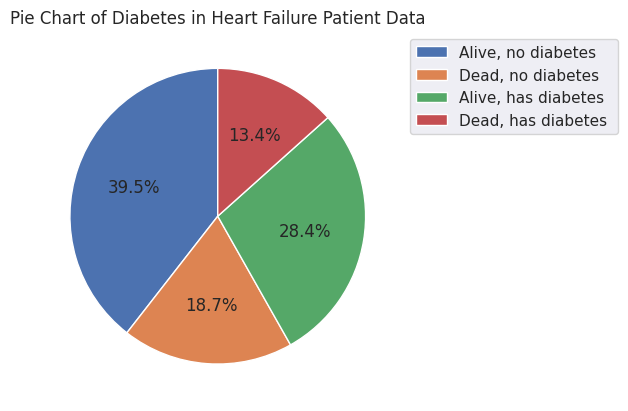

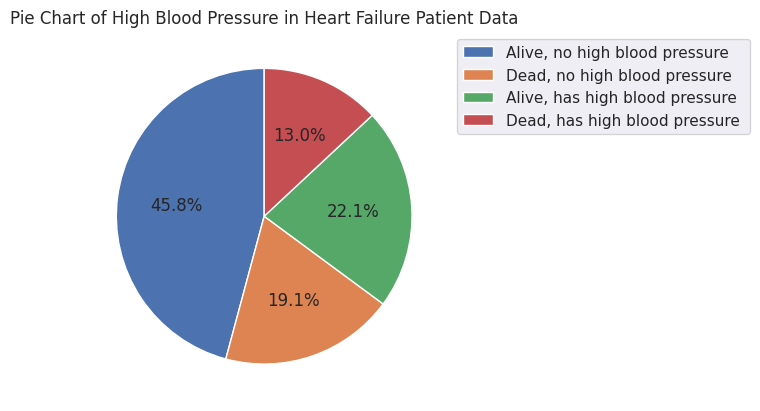

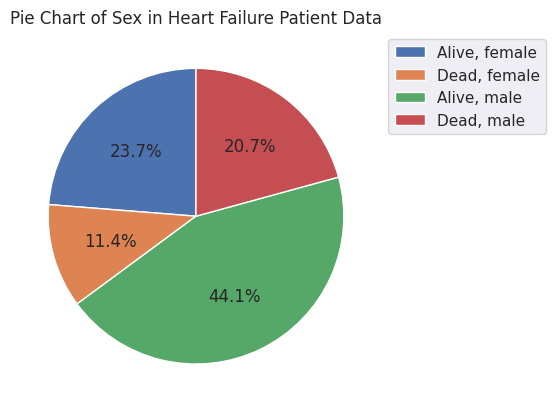

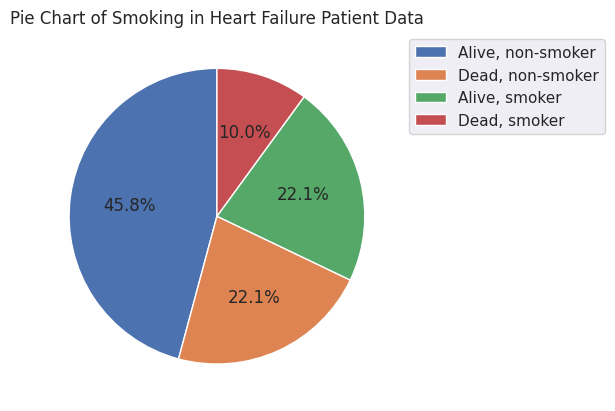

In [203]:
binary_var = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

for var in binary_var:
    group = train.groupby([var, 'death_event']).size().reset_index(name='count')
    total = group['count'].sum()
    group['percent'] = group['count'] / total * 100

    plt.pie(group['percent'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Pie Chart of {"".join(x[0].upper() + x[1:] + " " for x in var.split("_"))}in Heart Failure Patient Data')
    if var in ['anaemia', 'diabetes', 'high_blood_pressure']:
        plt.legend([f'Alive, no {"".join(x + " " for x in var.split("_"))}', f'Dead, no {"".join(x + " " for x in var.split("_"))}', f'Alive, has {"".join(x + " " for x in var.split("_"))}', f'Dead, has {"".join(x + " " for x in var.split("_"))}'],
                   bbox_to_anchor=(1, 1))
    elif var == 'sex':
        plt.legend([f'Alive, female', f'Dead, female', f'Alive, male', f'Dead, male'],
                   bbox_to_anchor=(1, 1))
    elif var == 'smoking':
        plt.legend([f'Alive, non-smoker', f'Dead, non-smoker', f'Alive, smoker', f'Dead, smoker'],
                   bbox_to_anchor=(1, 1))
    plt.show()

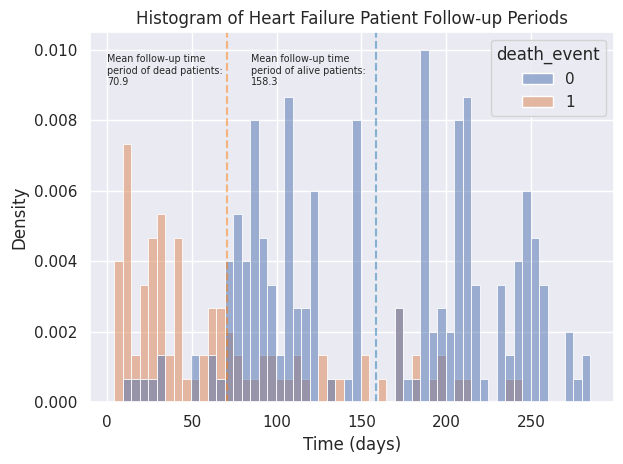

In [220]:
sns.histplot(train, x='time', 
             hue='death_event',
             stat='density',
             binwidth=5)
plt.axvline(train_grouped['time'][0],
            alpha=0.5, 
            c='tab:blue',
            ls='--')
plt.axvline(train_grouped['time'][1],
            alpha=0.5,
            c='tab:orange',
            ls='--'),
plt.annotate(f"Mean follow-up time\nperiod of alive patients:\n{train_grouped['time'][0]:.1f}",
             xy=(train_grouped['time'][0], 0.010),
             xytext=(85, 0.009),
             size='xx-small')
plt.annotate(f"Mean follow-up time\nperiod of dead patients:\n{train_grouped['time'][1]:.1f}",
             xy=(train_grouped['time'][1], 0.010),
             xytext=(0, 0.009),
             size='xx-small')
plt.title('Histogram of Heart Failure Patient Follow-up Periods')
plt.xlabel('Time (days)')
plt.tight_layout() 

Text(0.5, 1.0, 'Correlation Matrix of Heart Failure Patient Features')

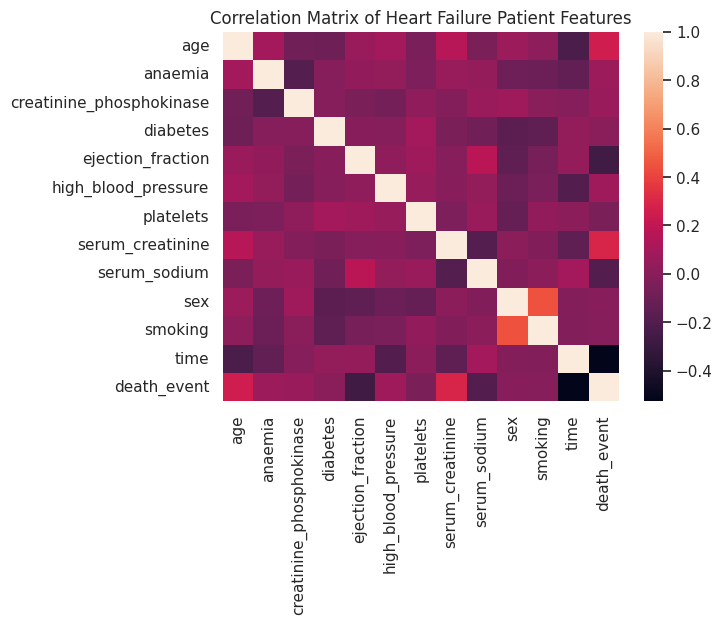

In [222]:
sns.heatmap(train.corr())
plt.title('Correlation Matrix of Heart Failure Patient Features')

In [237]:
top_corr = train.corr().unstack().sort_values(ascending=False).drop_duplicates()

top_corr[(top_corr >= 0.5) | (top_corr <= -0.5)]

age   age            1.000000
time  death_event   -0.526964
dtype: float64